### CLS transcript QTLs for gencode v47 paper

CLS transcript categories from: https://github.com/guigolab/CLS3_GENCODE/tree/main/data_release#gencode-cls3-mappings
protien coding and lncRNAs in v27 subsets from: https://github.com/guigolab/CLS3_GENCODE/tree/main/complementary_data/gencode_byotypes_datasets#2-gencode-v27-reference

In [127]:
import pandas as pd
import numpy as np
import seaborn as sns
import pyranges as pr
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf

from tqdm.notebook import tqdm

tqdm.pandas()

In [2]:
qval_cutoff = 0.05

load in gencode ids and biotypes, they used gencode v27 so that's what I will use for consistency 
they have manually subset the list of lncRNAs, so I'll just load in that list directly. 

In [44]:
v27_lncRNA = pd.read_csv('data/other_references/gencode/CLS_id_lists/annotation_lncRNA.bed.gz', sep='\t', header=None, names=['chr', 'start', 'end', 'gene_id'])
v27_lncRNA['gene_id_stable'] = v27_lncRNA['gene_id'].str.split('.').str[0]
v27_lncRNA['gene_type'] = 'lncRNA (v27)'
v27_lncRNA.drop_duplicates('gene_id_stable', inplace=True)


v27_protein_coding = pd.read_csv('data/other_references/gencode/CLS_id_lists/annotation_proteincoding.bed.gz', sep='\t', header=None, names=['chr', 'start', 'end', 'gene_id'])
v27_protein_coding['gene_id_stable'] = v27_protein_coding['gene_id'].str.split('.').str[0]
v27_protein_coding.drop_duplicates('gene_id_stable', inplace=True)
v27_protein_coding['gene_type'] = 'protein-coding (v27)'


v27_ids = pd.concat([v27_lncRNA, v27_protein_coding])

load in qtls

In [63]:
# load in the v11 qtls
v11_eqtl = pd.read_csv('/home/klawren/oak/gtex/output/caudate_analysis/eqtls/Brain_Caudate_basal_ganglia.v11.eGenes.txt.gz', sep='\t')
v11_sqtl= pd.read_csv('/home/klawren/oak/gtex/output/caudate_analysis/sqtls/Brain_Caudate_basal_ganglia.v11.sGenes.txt.gz', sep='\t')

# are they signifignat?
v11_eqtl['signifigant'] = v11_eqtl['qval'] < qval_cutoff
v11_sqtl['signifigant']  = v11_sqtl['qval'] < qval_cutoff

v11_eqtl['gene_id_stable'] = v11_eqtl['gene_id'].str.split('.').str[0]
v11_sqtl['gene_id_stable'] = v11_sqtl['gene_id'].str.split('.').str[0]


In [64]:
# expected df length
pd.concat([v27_ids['gene_id_stable'], v11_eqtl['gene_id_stable'], v11_sqtl['gene_id_stable']]).nunique()

37418

In [65]:
# combine into one df
def comine_qtls(gencode_ids, eqtls, sqtls):
    eqtls['is_tested'] = True
    eqtls = pd.merge(gencode_ids, eqtls[['signifigant', 'gene_id_stable', 'variant_id', 'qval', 'is_tested']], on='gene_id_stable', how='outer').reset_index(drop=True)
    sqtls['is_tested'] = True
    qtls = pd.merge(eqtls, sqtls[['signifigant', 'gene_id_stable', 'variant_id', 'qval', 'is_tested']], on='gene_id_stable', suffixes=['_e', '_s'],  how='outer').reset_index(drop=True)
    qtls[['signifigant_s', 'signifigant_e', 'is_tested_e', 'is_tested_s']] = qtls[['signifigant_s', 'signifigant_e', 'is_tested_e', 'is_tested_s']].fillna(False)
    return qtls

v11_qtls = comine_qtls(v27_ids, v11_eqtl, v11_sqtl)
v11_qtls['is_tested'] = v11_qtls['is_tested_e'] | v11_qtls['is_tested_s']

we are interested in three categories:
* Novel CLS
* lncRNAs (v27)
* protien coding (v27)



In [66]:
cls_categories = pd.read_csv('data/other_references/gencode/CLS_id_lists/v47-CLS3mapping_status.txt', sep='\t')

# this definition form tamaras email, should be 10043
cls_ids = cls_categories[(cls_categories['geneClassification'].isin(['Intergenic', 'Novel_Known_Intergenic'])) & (cls_categories['v47_biotype']=='lncRNA')]['geneID_v47'].unique()
len(cls_ids)

10043

In [ ]:
# this should be 0? again why isn't it?
# I think its becuase if any transcripts are new, the lncRNA goes in the new category
v11_qtls.loc[v11_qtls['gene_id_stable'].isin(cls_ids) & ~(v11_qtls['gene_type'].isna())]

,chr,start,end,gene_id,gene_id_stable,gene_type,signifigant_e,variant_id_e,qval_e,is_tested_e,signifigant_s,variant_id_s,qval_s,is_tested_s,is_tested
284,chr1,85578499.0,85578742.0,ENSG00000272691.1,ENSG00000272691,lncRNA (v27),False,chr1_86104653_C_T_b38,0.124555,True,False,NaN,NaN,False,True
734,chr10,3065423.0,3066001.0,ENSG00000273001.1,ENSG00000273001,lncRNA (v27),False,chr10_2109513_C_T_b38,0.103850,True,False,NaN,NaN,False,True
1485,chr12,5366047.0,5367774.0,ENSG00000256218.1,ENSG00000256218,lncRNA (v27),False,NaN,NaN,False,False,NaN,NaN,False,False
4474,chr2,78597910.0,78599406.0,ENSG00000234877.2,ENSG00000234877,lncRNA (v27),False,NaN,NaN,False,False,NaN,NaN,False,False
4492,chr2,91580335.0,91580863.0,ENSG00000261600.1,ENSG00000261600,lncRNA (v27),True,chr2_91641289_C_T_b38,0.001038,True,False,NaN,NaN,False,True
5037,chr20,40121040.0,40126357.0,ENSG00000223410.1,ENSG00000223410,lncRNA (v27),False,NaN,NaN,False,False,NaN,NaN,False,False
5427,chr22,25434323.0,25435070.0,ENSG00000272942.1,ENSG00000272942,lncRNA (v27),True,chr22_25459662_G_A_b38,0.000122,True,False,NaN,NaN,False,True
5524,chr22,45262272.0,45263585.0,ENSG00000273287.2,ENSG00000273287,lncRNA (v27),False,chr22_45485673_G_T_b38,0.309195,True,False,NaN,NaN,False,True
6139,chr4,65702201.0,65705553.0,ENSG00000248479.1,ENSG00000248479,lncRNA (v27),False,NaN,NaN,False,False,NaN,NaN,False,False
8369,chr9,10948371.0,10948481.0,ENSG00000270372.1,ENSG00000270372,lncRNA (v27),False,NaN,NaN,False,False,NaN,NaN,False,False


In [94]:
v11_qtls.loc[v11_qtls['gene_id_stable'].isin(cls_ids), 'gene_type'] = 'Novel CLS'
category_order = ['Novel CLS','lncRNA (v27)', 'protein-coding (v27)']
v11_qtls['gene_type'] = pd.Categorical(v11_qtls['gene_type'], categories=category_order, ordered=True)

v11_qtls.groupby(['gene_type']).size()

gene_type
Novel CLS                1435
lncRNA (v27)             8903
protein-coding (v27)    19805
dtype: int64

In [95]:
v11_qtls.groupby(['is_tested', 'gene_type']).size()

is_tested  gene_type           
False      Novel CLS                   5
           lncRNA (v27)             6089
           protein-coding (v27)     3454
True       Novel CLS                1430
           lncRNA (v27)             2814
           protein-coding (v27)    16351
dtype: int64

In [96]:
v11_qtls[v11_qtls['is_tested_e']].groupby(['signifigant_e', 'gene_type']).size()

signifigant_e  gene_type           
False          Novel CLS                853
               lncRNA (v27)            1312
               protein-coding (v27)    8262
True           Novel CLS                574
               lncRNA (v27)            1483
               protein-coding (v27)    8066
dtype: int64

### proportions plot

In [110]:
proportions = v11_qtls.groupby(['gene_type']).agg(
    e_significant_count=('signifigant_e', 'sum'),
    s_significant_count=('signifigant_s', 'sum'),
    e_tested_count=('is_tested_e', 'sum'),
    s_tested_count=('is_tested_s', 'sum'),
).reset_index()

proportions['e_proportion'] = proportions['e_significant_count'] / proportions['e_tested_count']
proportions['s_proportion'] = proportions['s_significant_count'] / proportions['s_tested_count']

melt_proportions = proportions.melt(id_vars=['gene_type'], value_vars=['e_proportion', 's_proportion'], value_name='proportion', var_name='qtl_type')
melt_proportions['qtl_type'] = melt_proportions['qtl_type'].str.split('_').str[0]

def get_ci(row):
    prop_row = proportions[(proportions['gene_type'] == row['gene_type'])].iloc[0]
    qtl_type = row['qtl_type']
    return 1.96 * np.sqrt((prop_row[f'{qtl_type}_proportion'] * (1 - prop_row[f'{qtl_type}_proportion'])) / prop_row[f'{qtl_type}_tested_count'])

def get_significant_count(row):
    prop_row = proportions[(proportions['gene_type'] == row['gene_type'])].iloc[0]
    qtl_type = row['qtl_type']
    return prop_row[f'{qtl_type}_significant_count']


def get_tested_count(row):
    prop_row = proportions[(proportions['gene_type'] == row['gene_type'])].iloc[0]
    qtl_type = row['qtl_type']
    return prop_row[f'{qtl_type}_tested_count']

melt_proportions['ci'] = melt_proportions.apply(get_ci, axis=1)
melt_proportions['significant_count'] = melt_proportions.apply(get_significant_count, axis=1)
melt_proportions['tested_count'] = melt_proportions.apply(get_tested_count, axis=1)

melt_proportions = melt_proportions.sort_values(['gene_type', 'qtl_type']).reset_index(drop=True).reset_index()
melt_proportions

,index,gene_type,qtl_type,proportion,ci,significant_count,tested_count
0,0,Novel CLS,e,0.402242,0.025442,574,1427
1,1,Novel CLS,s,0.153153,0.066998,17,111
2,2,lncRNA (v27),e,0.530590,0.018502,1483,2795
3,3,lncRNA (v27),s,0.311453,0.033921,223,716
4,4,protein-coding (v27),e,0.493998,0.007669,8066,16328
5,5,protein-coding (v27),s,0.206237,0.007137,2546,12345


/local/scratch/klawren/slrmtmp.47940907/ipykernel_55163/3044430761.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['eGenes', 'sGenes'], fontsize=7)


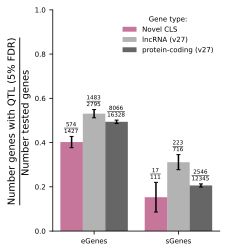

In [114]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 7

plt.figure(figsize=(3, 4))
ax = sns.barplot(melt_proportions, x='qtl_type', hue='gene_type', y='proportion', alpha=.6, 
                 palette={'Novel CLS':'#b70657', 'lncRNA (v27)':'grey', 'protein-coding (v27)':'black'})
x_coords = [p.get_x() + 0.5 * p.get_width() for p in ax.patches]
y_coords = [p.get_height() for p in ax.patches]
ax.errorbar(x=x_coords[:6], y=y_coords[:6], yerr=melt_proportions['ci'], fmt='none', c='k', capsize=2)

ax.set_ylabel(r'$\frac{\mathrm{Number\ genes\ with\ QTL\ (5\%\ FDR)}}{\mathrm{Number\ tested\ genes\ }}$', fontsize=14)
ax.spines[['top', 'right']].set_visible(False)
ax.set_ylim([0,1])
ax.set_xlabel('')
ax.set_xticklabels(['eGenes', 'sGenes'], fontsize=7)

sns.move_legend(ax, "upper right", bbox_to_anchor=(1, 1), frameon=False, title='Gene type:')


# Add bar labels for eQTL counts
for idx, row in melt_proportions.iterrows():
    # Calculate the position above the error bar
    y_position = y_coords[idx] + row['ci'] + 0.03  # Adjust the offset as needed
    ax.text(x=x_coords[idx], y=y_position, s=r'$\frac{{{}}}{{{}}}$'.format(row['significant_count'], row['tested_count']), ha='center', fontsize=8, color='black')


plt.show()

### nominal p values

In [321]:
new_eqtls = v11_qtls[(v11_qtls['gene_type']=='Novel CLS') & (v11_qtls['signifigant_e'])]

In [320]:
min_pval_nominal=[]
v11_dir_path = 'output/caudate_analysis/eqtls'

def get_min_pval_df(v11_dir_path, chr_id):
    v11_nominal_chr = pd.read_parquet(f'{v11_dir_path}/Brain_Caudate_basal_ganglia.v11.allpairs.chr{chr_id}.parquet')
    v11_nominal_chr = v11_nominal_chr[v11_nominal_chr['variant_id'].isin(new_eqtls['variant_id_e'])]
    v11_nominal_chr['gene_id_stable'] = v11_nominal_chr['gene_id'].str.split('.').str[0]
    v11_nominal_chr_other_genes = v11_nominal_chr[~v11_nominal_chr['gene_id_stable'].isin(cls_ids)]
    min_pval_idx = v11_nominal_chr_other_genes.groupby('variant_id')['pval_nominal'].idxmin()
    return v11_nominal_chr_other_genes.loc[min_pval_idx][['pval_nominal', 'gene_id_stable', 'variant_id']]

for chr_id in tqdm(range(1, 23)):
    min_pval_nominal.append(get_min_pval_df(v11_dir_path, chr_id))
min_pval_nominal.append(get_min_pval_df(v11_dir_path, 'X'))

  0%|          | 0/22 [00:00<?, ?it/s]

In [332]:
new_eqtls = pd.merge(new_eqtls, pd.concat(min_pval_nominal), how='left', left_on='variant_id_e', right_on='variant_id', suffixes=['', '_other_gene'])
print(sum(new_eqtls['pval_nominal'].isna()))
new_eqtls['pval_nominal'] = new_eqtls['pval_nominal'].fillna(1)

0


In [336]:
(new_eqtls['pval_nominal_other_gene'] > 0.05).mean() * 100

16.550522648083625

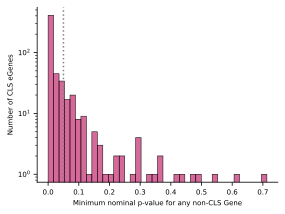

In [334]:
# show the distirbution of minimum p values for all the new qtls
fig, ax = plt.subplots(figsize=(4, 3))

sns.histplot(new_eqtls, x='pval_nominal_other_gene', ax=ax, bins=40,
             multiple='dodge', color='#b70657', alpha=.6)
ax.set_yscale('log')
ax.set_xlabel('Minimum nominal p-value for any non-CLS Gene')
ax.set_ylabel('Number of CLS eGenes')
ax.spines[['top', 'right']].set_visible(False)
ax.axvline(0.05, ls=':', color='grey')
fig.tight_layout()


### expression level of novel lncRNAs as covaraite?

Optimization terminated successfully.
         Current function value: 0.685406
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:       eQTL_significant   No. Observations:                 4222
Model:                          Logit   Df Residuals:                     4220
Method:                           MLE   Df Model:                            1
Date:                Fri, 18 Apr 2025   Pseudo R-squ.:                 0.01070
Time:                        16:14:00   Log-Likelihood:                -2893.8
converged:                       True   LL-Null:                       -2925.1
Covariance Type:            nonrobust   LLR p-value:                 2.523e-15
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.1225      0.038      3.232      0.001       0.048       0.197
novel[T.True]    -0.

/local/scratch/klawren/slrmtmp.47940907/ipykernel_55163/2612046895.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lncRNA_qtls['eQTL_significant'] = lncRNA_qtls['signifigant_e'].astype(int)
/local/scratch/klawren/slrmtmp.47940907/ipykernel_55163/2612046895.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lncRNA_qtls['novel'] = lncRNA_qtls['gene_type'] ==  'Novel CLS'


<AxesSubplot: xlabel='novel', ylabel='eQTL_significant'>

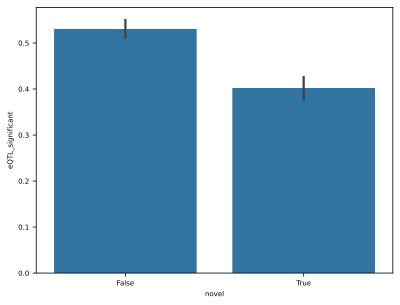

In [232]:
# Filter for tested genes
lncRNA_qtls = v11_qtls[v11_qtls['gene_type'].isin(['lncRNA (v27)', 'Novel CLS'])]
lncRNA_qtls['eQTL_significant'] = lncRNA_qtls['signifigant_e'].astype(int)
lncRNA_qtls['novel'] = lncRNA_qtls['gene_type'] ==  'Novel CLS'
tested_e = lncRNA_qtls[lncRNA_qtls['is_tested_e']]


# Run linear model for eQTL significance
model_e = smf.logit('eQTL_significant ~ novel', data=tested_e).fit()
print(model_e.summary())

sns.barplot(tested_e, y='eQTL_significant', x='novel')


In [ ]:
# add in expresssion median
v11_tpm = pd.read_csv('/home/klawren/oak/gtex/output/caudate_analysis/gene_tpm_v11_brain_caudate_basal_ganglia.gct.gz', sep='\t')
median_expression = v11_tpm.set_index('Name')[v11_tpm.columns[2:]].median(axis=1)
median_expression = pd.DataFrame(median_expression, columns=['median_expression']).reset_index()
median_expression['gene_id_stable'] = median_expression['Name'].str.split('.').str[0]
v11_qtls = pd.merge(v11_qtls, median_expression, on='gene_id_stable', how='left')

/local/scratch/klawren/slrmtmp.47940907/ipykernel_55163/1970603713.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lncRNA_qtls['eQTL_significant'] = lncRNA_qtls['signifigant_e'].astype(int)
/local/scratch/klawren/slrmtmp.47940907/ipykernel_55163/1970603713.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lncRNA_qtls['novel'] = lncRNA_qtls['gene_type'] ==  'Novel CLS'


Optimization terminated successfully.
         Current function value: 0.670247
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:       eQTL_significant   No. Observations:                 1408
Model:                          Logit   Df Residuals:                     1406
Method:                           MLE   Df Model:                            1
Date:                Fri, 18 Apr 2025   Pseudo R-squ.:               0.0009495
Time:                        16:28:59   Log-Likelihood:                -943.71
converged:                       True   LL-Null:                       -944.60
Covariance Type:            nonrobust   LLR p-value:                    0.1805
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.4634      0.061      7.581      0.000       0.344       0.583
novel[T.True]    -0.

<AxesSubplot: xlabel='novel', ylabel='eQTL_significant'>

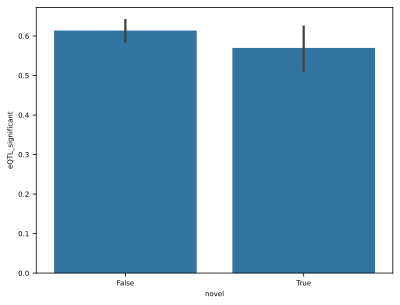

In [269]:
# Run linear model for eQTL significance including median_expression as a covariate
lncRNA_qtls = v11_qtls[v11_qtls['gene_type'].isin(['lncRNA (v27)', 'Novel CLS'])]
lncRNA_qtls['eQTL_significant'] = lncRNA_qtls['signifigant_e'].astype(int)
lncRNA_qtls['novel'] = lncRNA_qtls['gene_type'] ==  'Novel CLS'
high_expression_tested = lncRNA_qtls[lncRNA_qtls['is_tested_e'] & (lncRNA_qtls['median_expression'] > .5)]

model_binary = smf.logit('eQTL_significant ~ novel', data=high_expression_tested).fit()
print(model_binary.summary())

sns.barplot(high_expression_tested, y='eQTL_significant', x='novel')

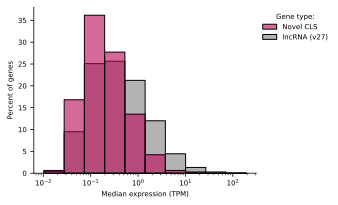

In [293]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 7

plt.figure(figsize=(4, 3))

ax = sns.histplot(lncRNA_qtls[lncRNA_qtls['is_tested_e']], hue='gene_type', x='median_expression', bins=10, log_scale=True, common_norm=False, stat='percent', 
             hue_order=['Novel CLS', 'lncRNA (v27)'], palette={'Novel CLS':'#b70657', 'lncRNA (v27)':'grey', 'protein-coding (v27)':'black'}, alpha=.6)
ax.spines[['top', 'right']].set_visible(False)
ax.set_ylabel('Percent of genes')
ax.set_xlabel('Median expression (TPM)')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), frameon=False, title='Gene type:')


In [274]:
bins = [-float('inf'), .5, 1, 5, float('inf')]
labels = ['< 0.5 TPM', '0.5 - 1 TPM', '1 - 5 TPM', '5+ TPM']

# Create a new column for the categorized median_expression
lncRNA_qtls['expression_category'] = pd.cut(lncRNA_qtls['median_expression'], bins=bins, labels=labels)


/local/scratch/klawren/slrmtmp.47940907/ipykernel_55163/3747503674.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lncRNA_qtls['expression_category'] = pd.cut(lncRNA_qtls['median_expression'], bins=bins, labels=labels)


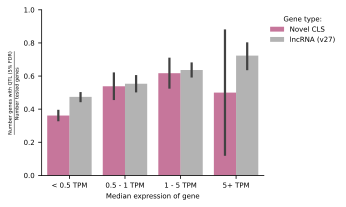

In [286]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 7

plt.figure(figsize=(4, 3))

ax = sns.barplot(lncRNA_qtls[lncRNA_qtls['is_tested_e']], y='eQTL_significant', hue='gene_type', x='expression_category', hue_order=['Novel CLS', 'lncRNA (v27)'], palette={'Novel CLS':'#b70657', 'lncRNA (v27)':'grey', 'protein-coding (v27)':'black'}, alpha=.6)
ax.spines[['top', 'right']].set_visible(False)
ax.set_ylim([0,1])
ax.set_xlabel('Median expression of gene')
ax.set_ylabel(r'$\frac{\mathrm{Number\ genes\ with\ QTL\ (5\%\ FDR)}}{\mathrm{Number\ tested\ genes\ }}$')

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), frameon=False, title='Gene type:')

plt.show()

#### Sanity check: compare with all v27 ids

In [34]:
# check if the CLS lncRNAs are in v27
gencode_v27=pr.read_gtf("/home/klawren/oak/gtex/data/other_references/gencode/gencode.v27.annotation.gtf.gz").as_df()
gencode_v27['gene_id_stable'] = gencode_v27['gene_id'].str.split('.').str[0]
gencode_v27_biotypes = gencode_v27.drop_duplicates('gene_id_stable')[['gene_id_stable', 'gene_type']]

In [38]:
# check the v27 ids match to what id expect
gencode_v27_biotypes[gencode_v27_biotypes['gene_id_stable'].isin(v27_protein_coding['gene_id_stable'])]['gene_type'].value_counts()

gene_type
protein_coding    19805
Name: count, dtype: int64

In [39]:
gencode_v27_biotypes[gencode_v27_biotypes['gene_id_stable'].isin(v27_lncRNA['gene_id_stable'])]['gene_type'].value_counts()

gene_type
lincRNA                          6817
antisense_RNA                    1105
TEC                               575
processed_transcript              265
sense_overlapping                  97
sense_intronic                     39
bidirectional_promoter_lncRNA      12
3prime_overlapping_ncRNA            2
macro_lncRNA                        1
Name: count, dtype: int64

In [40]:
# this should be 0, why isn't it??
gencode_v27['gene_id_stable'].isin(cls_ids).sum()

48

In [41]:
gencode_v27[gencode_v27['gene_id_stable'].isin(cls_ids)]

,Chromosome,Source,Feature,Start,End,Score,Strand,Frame,gene_id,gene_type,...,transcript_name,transcript_support_level,tag,havana_transcript,exon_number,exon_id,ont,protein_id,ccdsid,gene_id_stable
173072,chr1,HAVANA,gene,85578499,85578742,.,-,.,ENSG00000272691.1,lincRNA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ENSG00000272691
173073,chr1,HAVANA,transcript,85578499,85578742,.,-,.,ENSG00000272691.1,lincRNA,...,AC092807.2-201,NA,basic,OTTHUMT00000472331.1,NaN,NaN,NaN,NaN,NaN,ENSG00000272691
173074,chr1,HAVANA,exon,85578499,85578742,.,-,.,ENSG00000272691.1,lincRNA,...,AC092807.2-201,NA,basic,OTTHUMT00000472331.1,1,ENSE00003702827.1,NaN,NaN,NaN,ENSG00000272691
181524,chr1,HAVANA,gene,111317599,111323981,.,-,.,ENSG00000229283.1,antisense_RNA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ENSG00000229283
181525,chr1,HAVANA,transcript,111317599,111323981,.,-,.,ENSG00000229283.1,antisense_RNA,...,AL356387.1-201,3,basic,OTTHUMT00000030716.1,NaN,NaN,NaN,NaN,NaN,ENSG00000229283
181526,chr1,HAVANA,exon,111323833,111323981,.,-,.,ENSG00000229283.1,antisense_RNA,...,AL356387.1-201,3,basic,OTTHUMT00000030716.1,1,ENSE00001660412.1,NaN,NaN,NaN,ENSG00000229283
181527,chr1,HAVANA,exon,111317599,111317927,.,-,.,ENSG00000229283.1,antisense_RNA,...,AL356387.1-201,3,basic,OTTHUMT00000030716.1,2,ENSE00001665398.1,NaN,NaN,NaN,ENSG00000229283
265707,chr2,HAVANA,gene,78597910,78599406,.,+,.,ENSG00000234877.2,lincRNA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ENSG00000234877
265708,chr2,HAVANA,transcript,78597910,78599406,.,+,.,ENSG00000234877.2,lincRNA,...,AC092660.1-201,2,basic,OTTHUMT00000328311.2,NaN,NaN,NaN,NaN,NaN,ENSG00000234877
265709,chr2,HAVANA,exon,78597910,78597943,.,+,.,ENSG00000234877.2,lincRNA,...,AC092660.1-201,2,basic,OTTHUMT00000328311.2,1,ENSE00001776201.2,NaN,NaN,NaN,ENSG00000234877


In [61]:
# old way for all v27
v11_qtls = comine_qtls(gencode_v27_biotypes, v11_eqtl, v11_sqtl)

v11_qtls['grouped_category'] = None
v11_qtls.loc[v11_qtls['gene_type']=='protein_coding', 'grouped_category'] = 'protein-coding (v27)'
v11_qtls.loc[v11_qtls['gene_type'].isin(['3prime_overlapping_ncRNA', 'antisense', 'bidirectional_promoter_lncRNA', 'lincRNA', 'macro_lncRNA', 'non_coding', 'processed_transcript', 'sense_intronic','sense_overlapping']), 'grouped_category'] = 'lncRNAs (v27)'
v11_qtls.loc[v11_qtls['gene_id_stable'].isin(cls_ids), 'grouped_category'] = 'Novel CLS'
v11_qtls.groupby(['grouped_category']).size()

grouped_category
Novel CLS                1436
lncRNAs (v27)            9172
protein-coding (v27)    19818
dtype: int64

In [125]:
# number samples
pd.read_csv('output/caudate_analysis/eqtls/Brain_Caudate_basal_ganglia.v11.normalized_expression.bed.gz', sep='\t').shape[1] - 4

298